Data from - [Github](https://github.com/Rhitabrat/Youtube-Comments-Categorization), [Paper](https://arxiv.org/pdf/2111.01908.pdf)

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd

from string import digits
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
from tqdm import tqdm, notebook

import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/kaggle/input/youtube-videos-title-description-comments/GBvideos.csv
/kaggle/input/youtube-videos-title-description-comments/GBtext-details.csv
/kaggle/input/youtube-videos-title-description-comments/UScomments.csv
/kaggle/input/youtube-videos-title-description-comments/GB_category_id.json
/kaggle/input/youtube-videos-title-description-comments/US_category_id.json
/kaggle/input/youtube-videos-title-description-comments/UStext-details.csv
/kaggle/input/youtube-videos-title-description-comments/GBcomments.csv
/kaggle/input/youtube-videos-title-description-comments/USvideos.csv
/kaggle/input/pre-train-bert-on-youtube-comments/__results__.html
/kaggle/input/pre-train-bert-on-youtube-comments/__notebook__.ipynb
/kaggle/input/pre-train-bert-on-youtube-comments/__output__.json
/kaggle/input/pre-train-bert-on-youtube-comments/custom.css
/kaggle/input/pre-train-bert-on-you

In [3]:
import os
import random
import gc
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
sns.set(style='darkgrid')

from sklearn.model_selection import StratifiedKFold, train_test_split

%matplotlib inline

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoModel, BertForSequenceClassification, BertModel
from transformers import AutoTokenizer, BertTokenizer
from transformers import AutoConfig

In [5]:
DEBUG = False

DATA_PATH = '/kaggle/input/youtube-comments-categorization/youtube-comments-categorization.csv'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

SEED = 97
seed_everything(SEED)

Device:  cuda


In [20]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

In [21]:
def paraphrase(
    question,
    num_beams=5,
    num_beam_groups=5,
    num_return_sequences=5,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids.to(device)
    
    outputs = model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return res

In [22]:
BERT = 'bert-base-uncased'

In [23]:
cfg ={}
MODEL_PATH = BERT

In [24]:
df = pd.read_csv(DATA_PATH, header = None)
df.columns = ['comment', 'label']
df.head()

,comment,label
0,Love you sir!!,positive
1,Please make videos on..Midpoint circle drawing...,imperative
2,I bought both of your courses on Udemy. You ar...,interrogative
3,"Thank you very much, u really got me in the fi...",positive
4,i hope u are ok with everything going on again...,miscellaneous


In [25]:
len(df)

10000

/tmp/ipykernel_31/276136780.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=45)


<AxesSubplot: xlabel='label', ylabel='count'>

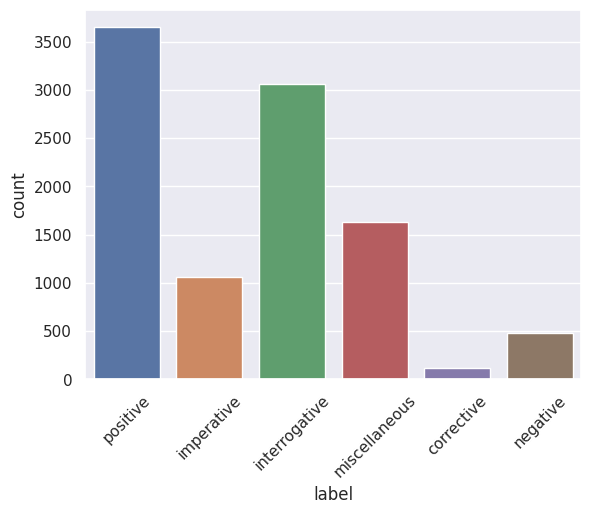

In [26]:
_, ax = plt.subplots()
labels = df.label.unique()
ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x='label', data=df, ax=ax)

In [27]:
df.label.unique()
labels = {'positive':0, 'imperative':1, 'interrogative':2, 'miscellaneous':3,
       'corrective':4, 'negative':5}
df['enc_label'] = df.label.apply(lambda x: labels[x])
df.head()

,comment,label,enc_label
0,Love you sir!!,positive,0
1,Please make videos on..Midpoint circle drawing...,imperative,1
2,I bought both of your courses on Udemy. You ar...,interrogative,2
3,"Thank you very much, u really got me in the fi...",positive,0
4,i hope u are ok with everything going on again...,miscellaneous,3


Paraphrasing for increasing the dataset for classes with less samples

In [28]:
text_imperative = df[df['enc_label'] == 1].comment.values
text_miscellaneous = df[df['enc_label'] == 3].comment.values
text_corrective = df[df['enc_label'] == 4].comment.values
text_negative = df[df['enc_label'] == 5].comment.values

In [29]:
len(text_imperative), len(text_miscellaneous), len(text_corrective), len(text_negative)

(1057, 1633, 121, 482)

In [30]:
phrases = df[df['enc_label'] == 1][0:2].comment.values
for phrase in phrases:
    print("-"*100)
    print("Input_phrase: ", phrase)
    print("-"*100)
    para_phrases = paraphrase(phrase)
    for para_phrase in para_phrases:
        print(para_phrase)

----------------------------------------------------------------------------------------------------
Input_phrase:  Please make videos on..Midpoint circle drawing And Bresenham's circle drawing...
----------------------------------------------------------------------------------------------------
Can you assist me in making videos? Both Midpoint and Bresenham's circular circles...
Would it be feasible for you to create videos on...?
I am looking for someone to make videos on...
Could you create videos on. Both Mimicil and Bresenham's circular circles...
Make sure to include videos on...
----------------------------------------------------------------------------------------------------
Input_phrase:  Sir please upload Approximation Algorithms videos also!! @AbdulBari
----------------------------------------------------------------------------------------------------
I would appreciate it if you could upload Approximation Algorithms videos, thanks to @AbdulBari.
Please upload Approximat

In [33]:
def get_paraphrases(texts, num_seq):
    phrases = []
    for text in notebook.tqdm(texts):
        para_phrases = paraphrase(text, num_return_sequences=num_seq)
        phrases = phrases + para_phrases
    return phrases

In [34]:
phrases_imperative = get_paraphrases(text_imperative, num_seq=1)
len(phrases_imperative)

  0%|          | 0/1057 [00:00<?, ?it/s]

1057

In [35]:
phrases_corrective = get_paraphrases(text_corrective, num_seq=5)
len(phrases_corrective)

  0%|          | 0/121 [00:00<?, ?it/s]

605

In [36]:
phrases_negative = get_paraphrases(text_negative, num_seq=2)
len(phrases_negative)

  0%|          | 0/482 [00:00<?, ?it/s]

964

In [37]:
imperative_df = pd.DataFrame(phrases_imperative)
imperative_df.columns = ['comment']
imperative_df['label'] = 'imperative'
imperative_df['enc_label'] = 1

corrective_df = pd.DataFrame(phrases_corrective)
corrective_df.columns = ['comment']
corrective_df['label'] = 'corrective'
corrective_df['enc_label'] = 4

negative_df = pd.DataFrame(phrases_negative)
negative_df.columns = ['comment']
negative_df['label'] = 'negative'
negative_df['enc_label'] = 5

df = pd.concat([df, imperative_df, corrective_df, negative_df], axis=0)
len(df)

12626

In [38]:
df.to_csv('over_sample_comments.csv')

/tmp/ipykernel_31/276136780.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=labels, rotation=45)


<AxesSubplot: xlabel='label', ylabel='count'>

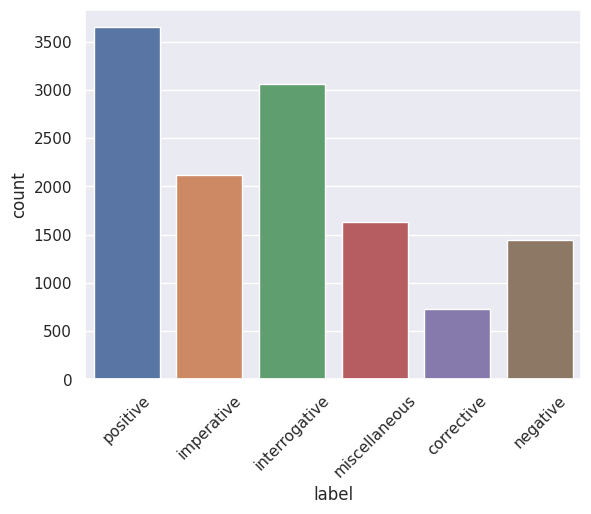

In [39]:
_, ax = plt.subplots()
labels = df.label.unique()
ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x='label', data=df, ax=ax)

In [40]:
X_train, X_temp, y_train, y_temp = train_test_split(df.comment, df.enc_label, test_size=0.3, random_state=SEED, stratify=df.enc_label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

<AxesSubplot: xlabel='enc_label', ylabel='count'>

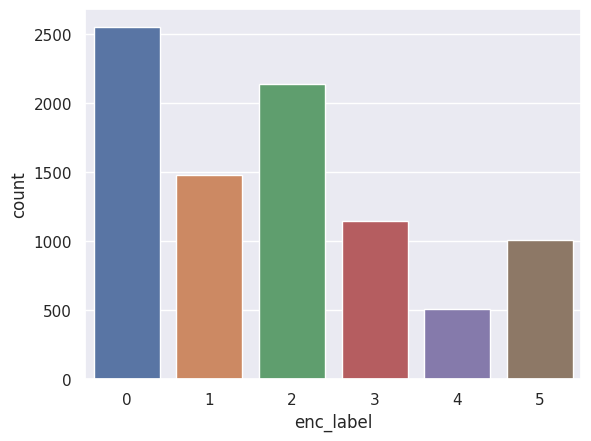

In [41]:
_, ax = plt.subplots()
# labels = df.label.unique()
# ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x=y_train, ax=ax)

<AxesSubplot: xlabel='enc_label', ylabel='count'>

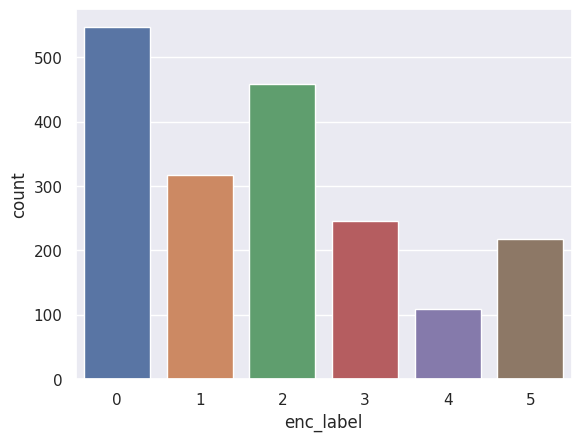

In [42]:
_, ax = plt.subplots()
# labels = df.label.unique()
# ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x=y_val, ax=ax)

<AxesSubplot: xlabel='enc_label', ylabel='count'>

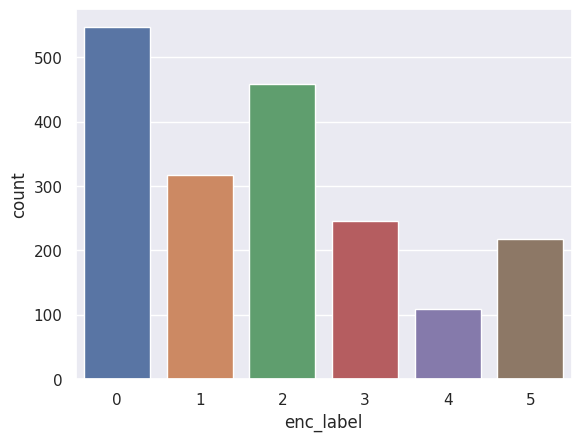

In [43]:
_, ax = plt.subplots()
# labels = df.label.unique()
# ax.set_xticklabels(labels=labels, rotation=45)
sns.countplot(x=y_test, ax=ax)

In [44]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [45]:
train_df.head()

,comment,enc_label
0,It didn't make sense when I used name = input ...,5
1,what's the website name again?,2
2,"In the algorithm, the initial value of p is co...",4
3,"Hey Phil, Wanna appreciate your help, over th...",2
4,sir is it good to use of eclipse for java begi...,2


In [46]:
SAVED_MODEL_PATH = '/kaggle/input/pre-train-bert-on-youtube-comments/bert-base-uncased-youtube-comments'

In [47]:
cfg['tokenizer'] ={'name': MODEL_PATH, 'max_length': 256}
tokenizer = BertTokenizer.from_pretrained(cfg['tokenizer']['name'])

In [48]:
cfg['train_batch_size'] = 32
cfg['valid_batch_size'] = 16
cfg['max_length'] = 256
cfg['epochs'] = 5
cfg['learning_rate'] = 1e-05

In [49]:
class CommentsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        comment = self.df.loc[index, 'comment']
        inputs = self.tokenizer.encode_plus(
            comment,                                 
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        
        if cfg['tokenizer']['name']=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids'] 
        else:
            token_type_ids = 1.
        
        target = self.df.loc[index, 'enc_label']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }
    
    def __len__(self):
        return self.len

In [50]:
train_data = CommentsDataset(train_df, tokenizer, cfg['max_length'])
val_data = CommentsDataset(val_df, tokenizer, cfg['max_length'])
test_data = CommentsDataset(test_df, tokenizer, cfg['max_length'])

In [51]:
def collate_fn(data):
    text = []
    target = []
    for tupl in data:
        text.append(tupl[0])
        target.append(tupl[1])
    zipped = zip(text, target)
    return list(zipped)

In [52]:
train_params = {'batch_size': cfg['train_batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': cfg['valid_batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

# train_loader = DataLoader(train_data, **train_params, collate_fn=collate_fn)
# val_loader = DataLoader(val_data, **valid_params, collate_fn=collate_fn)
# test_loader = DataLoader(test_data, **test_params, collate_fn=collate_fn)

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [53]:
class CommentRelevanceBERT(torch.nn.Module):
    def __init__(self, model_name):
        super(CommentRelevanceBERT, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.model_name = model_name
        
        self.in_features = self.bert.pooler.dense.out_features
            
        self.dense = nn.Linear(self.in_features, self.in_features)
        self.activation = nn.ReLU()
        self.layer_norm = nn.LayerNorm(self.in_features)
        self.dropout = nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, len(labels))

    def forward(self, input_ids, attention_mask, token_type_ids):    
        last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        
        output = self.layer_norm(output)
        output = self.dropout(output)
        output = self.classifier(output)
        return output

In [54]:
model = CommentRelevanceBERT(SAVED_MODEL_PATH)
model.to(device)

Some weights of the model checkpoint at /kaggle/input/pre-train-bert-on-youtube-comments/bert-base-uncased-youtube-comments were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CommentRelevanceBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [55]:
from torch.optim.lr_scheduler import StepLR
from transformers import get_cosine_schedule_with_warmup

In [56]:
num_training_steps = cfg['epochs']*len(train_loader)
num_warmup_steps = 0
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=cfg['learning_rate'])
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

In [57]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [58]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    
    print("Start training...\n")
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())
            
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            print("-"*70)
        print("\n")
    
    print("Training complete!")

In [59]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Learning rate = 1e-03, model loss was not reducing at all. Reduced learning rate to 1e-05, loss started reducing. 

In [60]:
train(model, loss_function, train_loader, val_loader, epochs=5, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.726041   |     -      |     -     |   15.88  
   1    |   40    |   1.342921   |     -      |     -     |   14.99  
   1    |   60    |   1.072613   |     -      |     -     |   15.11  
   1    |   80    |   0.860932   |     -      |     -     |   14.99  
   1    |   100   |   0.872363   |     -      |     -     |   15.06  
   1    |   120   |   0.726007   |     -      |     -     |   15.01  
   1    |   140   |   0.726691   |     -      |     -     |   15.01  
   1    |   160   |   0.669288   |     -      |     -     |   15.05  
   1    |   180   |   0.674809   |     -      |     -     |   15.00  
   1    |   200   |   0.687818   |     -      |     -     |   15.03  
   1    |   220   |   0.581207   |     -      |     -     |   15.11  
   1    |   240   |   0.586681   |     -      |     -     |   15.00  


KeyboardInterrupt: 

* 82.25 = bert dropout 0.3, no layer norm, 3 epochs
* 82.31 = no droputout, layer norm, 3 epochs
* 82.03 = '', '', batch size = 64, distill bert, 5 epochs
* 84.04 = robert 5 epochs
* 84.02 = pre-trained bert 5 epochs, overfitting on training set - train loss = 0.22, val_loss - 0.488

In [ ]:
output_model_file = 'fine-tuned-pretrained-bert-youtube-comments.pth'
torch.save(model, output_model_file)

In [ ]:
test_loss, test_accuracy = evaluate(model, loss_function, test_loader)
test_loss, test_accuracy

In [ ]:
def predict(model, loss_fn, val_dataloader):
    model.eval()

    preds = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)
        
        loss = loss_fn(outputs, targets)
        _, max_ids = torch.max(outputs.data, dim=1)
        preds.extend(max_ids.cpu().numpy())

    return preds

In [ ]:
preds = predict(model, loss_function, test_loader)
len(preds), len(test_df)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds[:10], y_test[:10]

In [ ]:
report = classification_report(y_test, preds, labels=[0, 1, 2, 3, 4, 5])
print(report)